# Ejemplo de Detección usando YOLO v3

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Descargar los siguientes archivos:
* `yolov3.weights`: pesos de yolo v3 pre entrenado en COCO (80 clases)
* `yolov3.cfg`: configuración de la arquitectura y parámetros de yolov3
* `coco.names`: nombres de las 80 clases de COCO

In [3]:
!wget -q https://pjreddie.com/media/files/yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

Cargar el modelo de yolo v3 con los pesos descargados

In [4]:
# Cargar YOLO pre-entrenado
yolo = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

Cargar las clases (nombres) de COCO y los nombres de las capas de YOLO.

In [5]:
# Clases de COCO
clases = []
with open("coco.names", "r") as f:
    clases = [line.strip() for line in f.readlines()]

# Capas de YOLO
capas_salida = [nombre_capa for nombre_capa in yolo.getUnconnectedOutLayersNames()]
capas_salida

['yolo_82', 'yolo_94', 'yolo_106']

In [6]:
# Generar colores  para graficar rectángulos
colors = np.random.uniform(0, 255, size=(len(clases), 3))

Cargar una imagen y obtener su tamaño y número de canales

In [7]:
# Cargar la imagen
I = cv2.imread("cat-dog.jpg")

height, width, channels = I.shape

Pre-procesamiento de la imagen usando escalamiento, sustracción de media e intercambio de canales R y B. Igualmente, se redimensiona la imagen al tamaño especificado por `size`.


In [8]:
blob = cv2.dnn.blobFromImage(I, scalefactor=0.00392, size=(416, 416), mean=(0,0,0), swapRB=True, crop=False)

Predicción de los objetos usando YOLO en la imagen

In [9]:
# Indicar la entrada (imagen pre-procesada) a YOLO
yolo.setInput(blob)

# Realizar la predicción con YOLO
salidas_red = yolo.forward(capas_salida)

"Parsing" de la información de salida de Yolov3: cuadros delimitadores (boxes), clases detectadas, y confiabilidades de las detecciones.

In [10]:
# Mostrar la información en la pantalla
IDs_clases = []
confiabilidades = []
boxes = []
for salida in salidas_red:
    for deteccion in salida:
        scores = deteccion[5:]
        ID_clase = np.argmax(scores)
        confiabilidad = scores[ID_clase]
        # Objeto detectado
        if confiabilidad > 0.5:
            # Centro del objeto
            x_centro = int(deteccion[0]*width)
            y_centro = int(deteccion[1]*height)
            # Tamaño del objeto
            w = int(deteccion[2]*width)
            h = int(deteccion[3]*height)
            # Coordenadas del rectángulo alrededor del objeto
            x = int(x_centro - w/2)
            y = int(y_centro - h/2)
            boxes.append([x, y, w, h])
            confiabilidades.append(float(confiabilidad))
            IDs_clases.append(ID_clase)          


Supresión de no máximos (non-maximum suppression) en los cuadros delimitadores encontrados, y dibujo de los cuadros en la imagen

In [11]:
indices = cv2.dnn.NMSBoxes(boxes, confiabilidades, 0.5, 0.4)

font = cv2.FONT_HERSHEY_PLAIN
Iout = I.copy()
for i in range(len(boxes)):
    if i in indices:
        x, y, w, h = boxes[i]
        label = str(clases[IDs_clases[i]])
        color = colors[i]
        cv2.rectangle(Iout, (x,y), (x+w, y+h), color, 2)
        cv2.putText(Iout, label, (x,y+30), font, 2, color, 3)

Mostrar la imagen usando matplotlib o usando OpenCV (en este caso se usará matplotlib)

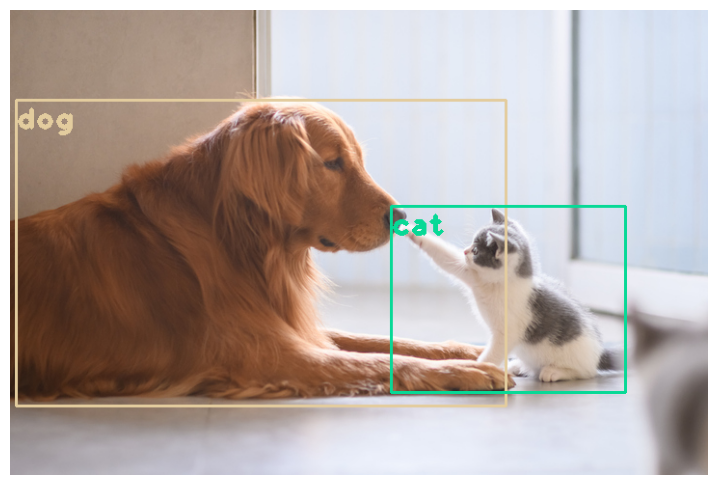

In [12]:
USE_PLT = True

if (USE_PLT):
    plt.figure(figsize=(9,9))
    plt.imshow(cv2.cvtColor(Iout, cv2.COLOR_BGR2RGB))
    plt.axis('off'); 
else:
    cv2.imshow("Image", Iout)
    cv2.waitKey(0)
    cv2.destroyAllWindows()